In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.stats as stats

import pandas as pd 
import seaborn as sns

%matplotlib inline

## Review

We have considered a time series for an asset $i$'s excess return that can be explained by a linear combination of factors that are shared across different assets.

$$R_{i,t}^e = \sum_\nu\beta_{i,\nu} F_{\nu,t} + \sigma_i \epsilon_{i,t},$$

where $F_{\nu,t}$ is a time series of the "returns" of risk factor $\nu$ that all stocks are exposed to in some way. The expected value of the factor is $\langle F_{\nu,t}\rangle =\lambda_\nu$ and $\langle F_{\nu,t}^2\rangle = \sigma_{\nu}^2$.
The sensitivity of an asset to the risk factor is given by its factor loading $\beta_i$. 
We still have the random error term, and by removing the common factors, we assume $\epsilon_{i,t}$ is now truly idiosyncratic, following $N(0,1)$.



# Merton Model for Credit Risk

In the Merton model, a company $i$ has a certain amount of zero-coupon debt; this debt has the face value $K_i$ and becomes due at maturity time T. 
The company defaults if its net worth or value at time T is less than the face value of the debt, i.e., if $V_i(T) < K_i$.
We model the value of the company as a stochastic process, more precisely, as a Geometric Brownian Motion with drift, driven by the market factor:

$$\frac{\mathrm{d}V_i}{V_i} = \mu\mathrm{d}t + \beta_i \mathrm{d}F + \sigma_i \mathrm{d}W_i.$$

(We can expand this equation to include interest payments or dividends, but let's keep the example simple.)

Under this equation, the probability of default of firm $i$ is

$$PD_i = \int_0^{K_i} p\left(V_i(T)\right)\mathrm{d}V_i(T),$$

which is the shaded area in the figure below.

<img src="Merton.png" alt="Merton Model" style="width: 300px;"/>


If the company fails to make its payment in full when it becomes due at $t=T$, the lender suffers the so-called Loss Given Default:

$$LGD_i = \frac{K_i-V_i(T)}{K_i}.$$

We are going to implement this model and explore the role the individual parameters play. To this end, we move to discrete time where the final value of the firm is

$$V_i(T) = V_i(0)\times\Pi_{t=1}^T\left(1+\mu\Delta t + \beta_i \sigma_F \epsilon_{F,t}\sqrt{\Delta t} + \sigma_i\epsilon_{i,t}\sqrt{\Delta t}\right).$$

We are going to set $\mu = 0$, and we measure $t$ in days, so $\Delta t = 1$.
Then, the equation above becomes

$$V_i(T) = V_i(0)\times\Pi_{t=1}^T\left(1+\beta_i \sigma_F \epsilon_{F,t} + \sigma_i\epsilon_{i,t}\right).$$

To get an estimate for the default probability, run 5000 simulations and report the number of times the final value of the firm ends below the amount of debt due. $PD_i$ then is the number of defautls divided by the number of runs.

Use the following parameters:
<ul>
    <li>$V_i(0) = 100$
    <li>$\beta = 0.5$
    <li>$\lambda_F = 0.08 / 252$
    <li>$\sigma_F = 0.15 / \sqrt{252}$
    <li>$\sigma_i = 0.25 / \sqrt{252}$
</ul>
As usual, $\epsilon_{F,t}, \epsilon_{i,t}$ are normally distributed with zero mean and unit variance.

#### Problem 1.
Find the default probability $PD_i$ for $T=10, 20, 30, \dots, 300$ and plot your result for $K=75, 90, 105$. Explain the $T$-dependence.

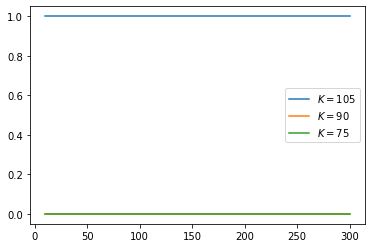

In [20]:
# Starting point for your code.

beta=0.5
sigma_f=0.15/np.sqrt(252)
sigma_i=0.25/np.sqrt(252)
lambda_f=0.08/252


def def_rate(V0, K, T, runs=1000):
    pd = 0
    for run_idx in range(runs):
        epsilon_f = np.random.normal(lambda_f,sigma_f,T)
        epsilon_i = np.random.normal(0,sigma_i,T)
        V = V0
        for time_step in range(T):
            mult_factor = 1 + beta*sigma_f*epsilon_f[time_step] + sigma_i*epsilon_i[time_step] 
            V *= mult_factor
        # Determine if V < K 
        if V < K:
            pd += 1
    return 1.*pd / runs

fig, ax = plt.subplots()

T = range(10,301,10)
ax.plot(T, [def_rate(100, 105, t, 1000) for t in T], label=r'$K=105$')
ax.plot(T, [def_rate(100,  90, t, 1000) for t in T], label=r'$K=90$')
ax.plot(T, [def_rate(100,  75, t, 1000) for t in T], label=r'$K=75$')
ax.legend()

We've encountered the so-called volatility drag already when we talked about the stock price. 
Log-prices follow a normal distribution with mean $\mu-\sigma^2/2$ where $\mu$ was the drift of the random walker, and $\sigma$ was the standard deviation. Because we are continuously compounding, a draw-down impacts the final price. In the same way, firms whose value fluctuates strongly have a lower expected firm value at time $T$.

In the single factor model, the risk or variance of a firm is 

$$\sigma^2_{tot} = \beta_i^2\sigma_F^2 + \sigma_i^2.$$

We will study how, for a fixed time horizon, the variation of $\beta_i$ and $\sigma_i$ are going to change the default risk.

#### Problem 2. 
Use the following parameters
<ul>
    <li>$V_i(0) = 100$
    <li>$K = 90$
    <li>$T = 100$
    <li>$r_f = 0.02 / 252$
    <li>$\lambda_F = 0.05 / 252$
    <li>$\sigma_F = 0.15 / \sqrt{252}$
</ul>
to study how a variation of $\beta_i$ and $\sigma_i$ affects $PD_i$. Make a heatmap (```sns.heatmap(..)```) with $\beta_i$ and $\sigma_i$ on the axes. Comment on the results.

Note: Here, nested lists are going to be useful:

```python
[[a+b for a in range(2)] for b in range(3)]```

is going to output a list ```[[0, 1], [1, 2], [2, 3]]```, which has 3 elements, from the command ```range(3)```, where each element is a list of two elements, from the command ```range(2)```.

To create a range with decimal values, use ```np.arange(x_min, x_max_excl, step)```. Note that like with all ranges the upper bound is exclusive.

Because we're running so many iterations, the computation time may be a little longer than usual.

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(def_rate_BE, cmap="Blues")
ax.set_xticklabels(["{:.1f}".format(_) for _ in np.arange(-1.1, 3.1, 0.2)], rotation = 90);
ax.set_yticklabels(["{:.1f}".format(_) for _ in np.arange(0.10, 3.01, 0.15)], rotation = 0);


#### Problem 3a
Plot an ensemble of realizations of the geometric Brownian walk for $T=100, \sigma_i= 0.2\sqrt{252}$ and the $\lambda_F, \sigma_F$ from above. Compare the random walkers for $\beta=0.5$ and $\beta=2.0$ and comment

In [ ]:
T = 100
realizations_low_beta, realizations_high_beta = [], []

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
ax1.plot(...);
ax2.plot(...);
ax1.set_ylim(0,220);
ax2.set_ylim(0,220);

#### Problem 3b

Find the loss given default for the low $\beta$ and for the high $\beta$ realizations.



# Factor Models for Fixed Income
We considered fundamental factors, leading to the Capital Asset Pricing Model (CAPM) and the Fama-French 3-Factor Model (FF). We further looked at macroeconomic factors in the homework, albeit their construction is quite involved and their explanatory power is rather limited.

How did we get to the idea of factor models in the first place? We looked at the correlation matrix $C$ and the covariance matrix $\Sigma$ which exhibited some structure. On a statistical level, we noticed that the eigenvalues of the correlation matrix were not distributed as we'd expect if the time series of returns $R_{i,t}$ was completely explained by firm-specific random noise. This opens a third avenue to find factors: dimensional reduction to extract statistical factors. 

## Principal Component Analysis

PCA is a tool to find structure in a covariance or correlation matrix by identifying a subspace of lower dimension which explains much of the variance.

Consider the following 3-dimensional data set $Y_i = (y_{i,1}, y_{i,2}, y_{i,3})$ generated with mean ${\bf\mu}=(\mu_1, \mu_2,\mu_3)$ from a covariance matrix $\Sigma$.

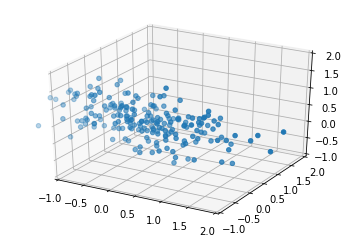

In [2]:
mu = np.array([0.1, 0.2, 0.3])
cov = [[ 0.840, 0.032, -0.064],
       [ 0.032, 0.040,  0.040],
       [-0.064, 0.040,  0.160]]

# cov = np.diag(np.array([1.0,0.6,0.2]))

Y = np.random.multivariate_normal(mu, cov, 200).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[0], Y[1], Y[2])
ax.set_xlim(-1,2);
ax.set_ylim(-1,2);
ax.set_zlim(-1,2);

On first inspection, there is some structure visible. Luckily, we can visualize and comprehend 3-dimensional graphs. But what if the data has more dimensions? 

Let's start exploring this question on the 3D data. We can reduce the graph to two dimensions, albeit with a loss of information. How do we minimize the loss? To answer this question, we have to think about what we're losing in the first place: variance. The data is heterogeneous in three dimensions, but if we could transform our coordinate system and kick out one dimension, how do we keep the most variance?

PCA offers a way forward. First, let's de-mean our variables, $\psi_i = Y_i - \langle Y_i\rangle$, so that we only have to worry about the variance. This is not a necessary step, but it simplifies the notation significantly.

How do we have to project $\psi_i$ to lower dimension and keep the largest amount of variance? Mathematically, we want to pick a vector $\alpha$ with $\lvert\lvert\alpha\rvert\rvert^2 = 1$ to maximize $\mathrm{Var}(\alpha^T\psi_i) = \alpha^T\Sigma\alpha$.

What would that vector be? It turns out we have to go back to eigenvalues and eigenvectors to come to the answer.

The covariance matrix of $\psi$ can be rewritten with its eigenvectors $\lambda_1>\lambda_2>\lambda_3$ and $O = (o_1, o_2, o_3)$, the orthogonal matrix of its eigenvectors:

$$\Sigma = 
O
\begin{pmatrix}
    \lambda_1 & 0 & 0 \\ 
    0 & \lambda_2 & 0 \\ 
    0 & 0 & \lambda_3 
\end{pmatrix}O^T.$$

It can be shown that the eigenvector belonging to the largest eigenvalue of the covariance matrix maximizes the variance, that is, we need to choose $\alpha = o_1.$ We call this eigenvector the first principal component. 

Largest eigenvalue: 0.847
Corresponding eigenvector: ['-0.995', '0.075', '0.062']


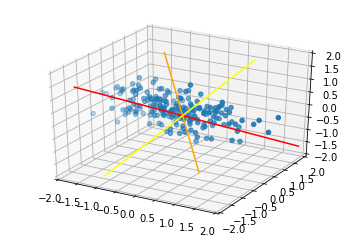

In [3]:
# Demean
psi = (Y.T - np.mean(Y)).T

# Calculate eigenvalues and eigenvectors
eigval, eigvec = np.linalg.eigh(cov)
# Sort eigenvalues and eigenvectors corresponding to the size of the eigenvalue.
eigvec = eigvec[:, np.argsort(eigval)[::-1]]
eigval = eigval[np.argsort(eigval)[::-1]]

print "Largest eigenvalue:", "{:.3f}".format(eigval[0])
print "Corresponding eigenvector:", ["{:.3f}".format(ev) for ev in eigvec[0]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(psi[0], psi[1], psi[2])
ax.set_xlim(-2,2);
ax.set_ylim(-2,2);
ax.set_zlim(-2,2);

ax.plot(np.array([_*eigvec[0] for _ in np.linspace(-3,3,10)]).T[0],
        np.array([_*eigvec[0] for _ in np.linspace(-3,3,10)]).T[1],
        np.array([_*eigvec[0] for _ in np.linspace(-3,3,10)]).T[2], 
       c="red");


ax.plot(np.array([_*eigvec[1] for _ in np.linspace(-3,3,10)]).T[0],
        np.array([_*eigvec[1] for _ in np.linspace(-3,3,10)]).T[1],
        np.array([_*eigvec[1] for _ in np.linspace(-3,3,10)]).T[2], 
       c="orange");


ax.plot(np.array([_*eigvec[2] for _ in np.linspace(-3,3,10)]).T[0],
        np.array([_*eigvec[2] for _ in np.linspace(-3,3,10)]).T[1],
        np.array([_*eigvec[2] for _ in np.linspace(-3,3,10)]).T[2], 
       c="yellow");

We can use principal component analysis as a filter as well. Let's say we believe that only three statistical features describe most of the features of a time series. Then we should be able to write the time series in good approximation as

$$Y_i = \beta_0 + \beta_{1,i} F_1 + \beta_{2,i} F_2 + \beta_{3,i} F_3 + u_i,$$

where $F_\nu$ are the factors, the $\beta_i$'s are the factor loadings, and $u_i$ is an uncorrelated error term.

When we want to reduce the time series to only three factors, though, we want to keep as much variance as possible -- and that's why we choose the first three principal components!

This does not work well for stock returns, unfortunately, because we don't have an interpretation for the factors. However, treasury rates and the yield curve are a good example. 

## Yield Curves

On Blackboard, we have a file for Yield Curve data that you need to download. The interest rates over different time horizons are plotted below. 

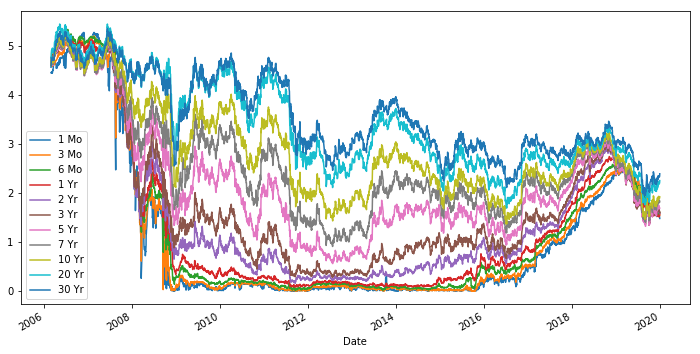

In [6]:
tr_df = pd.read_csv("./YieldCurve.csv", index_col=0, parse_dates=True).dropna()

tr_df.plot(figsize=(12,6))

#### Problem 4
Plot the yield curve for the last data point of each year. 
The command ```.resample("Y").last()``` will be helpful for this.

Remember that you first need to translate the months / years in the column headers to numerical data to get an accurate depiction of the times -- the time difference between "1 Mo" and "3 Mo" is different than the time difference between "20 Yr" and "30 Yr". You can acess the columns of a DataFrame ```df``` using ```df.columns```, where you can overwrite them.

Describe the shapes you find.

In our introduction to PCA, we could interpret the first principle component as follows: It was the vector that spanned the axis of space along which there was the most variation in the data. It was a purely geometrical interpretation.

In the case of yield curves, we can actually identify "yield curve behaviors" or "characteristics" that are captured by the first three principal components.

#### Probem 5
Find the first three principal components of the yield curve data. Remember for the covariance matrix that we compare data across time, and not across bond maturities. Plot them and interpret them.

Note: Look at the ```sklearn.decomposition``` package which allows to do PCA analysis such that you only have to enter the data and the number of features you want to extract.

In [7]:
import sklearn.decomposition.pca as PCA

pca = PCA.PCA(n_components=3)
pca.fit(tr_df)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)